# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
os.cpu_count()

12

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import re
from sklearn.svm import SVC

In [5]:
train_df = pd.read_csv(r"C:\Study\Coding\Python\Machine_Learning\Genre Classification Dataset\train_data.txt",sep=':::',names=['Title', 'Genre', 'Description'], engine='python')
test_df = pd.read_csv(r"C:\Study\Coding\Python\Machine_Learning\Genre Classification Dataset\test_data.txt",sep=':::',names=["Title","Genre","Description"],engine='python')

In [6]:
train_df.head(10)

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
6,Quality Control (2011),documentary,Quality Control consists of a series of 16mm ...
7,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...
8,One Step Away (1985),crime,Ron Petrie (Keanu Reeves) is a troubled teen ...
9,"""Desperate Hours"" (2016)",reality-tv,"A sudden calamitous event, causing great loss..."
10,Spirits (2014/I),horror,Four high school students embark on a terrify...


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [8]:
train_df.columns

Index(['Title', 'Genre', 'Description'], dtype='object')

In [9]:
train_df.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [10]:
### Counting Null values
train_df.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [11]:
test_df.head(10)

,Title,Genre,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...
5,6,Riddle Room (2016),Emily Burns is being held captive in a room w...
6,7,L'amica (1969),The beautiful but neglected wife of a brillia...
7,8,Ina Mina Dika (1989),Vasu Inamdar (Ina) suffers from a disorder wh...
8,9,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...
9,10,Press (2011),Press is a story of young people overwhelmed ...


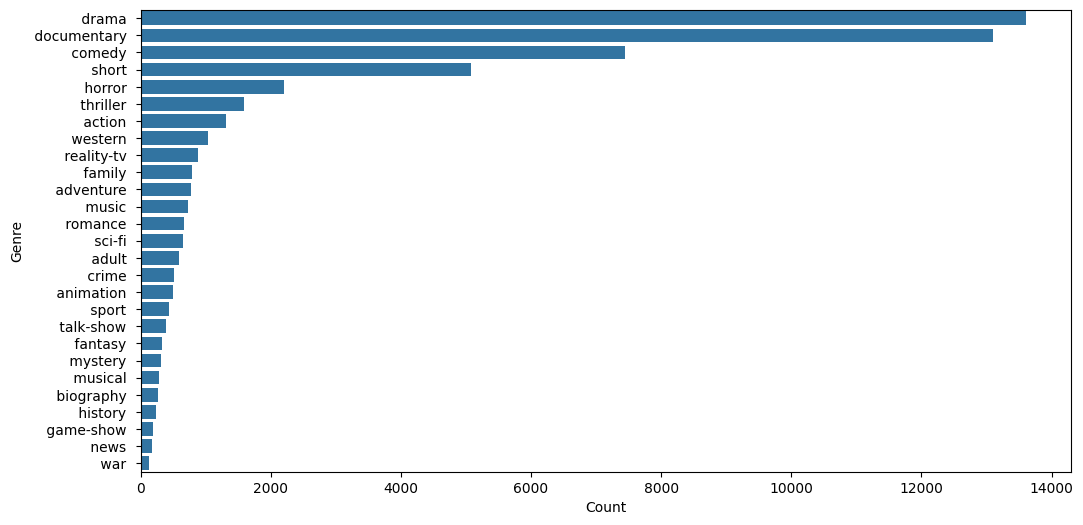

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(data=train_df,y="Genre",order = train_df["Genre"].value_counts().index)
plt.xlabel("Count")
plt.ylabel("Genre");

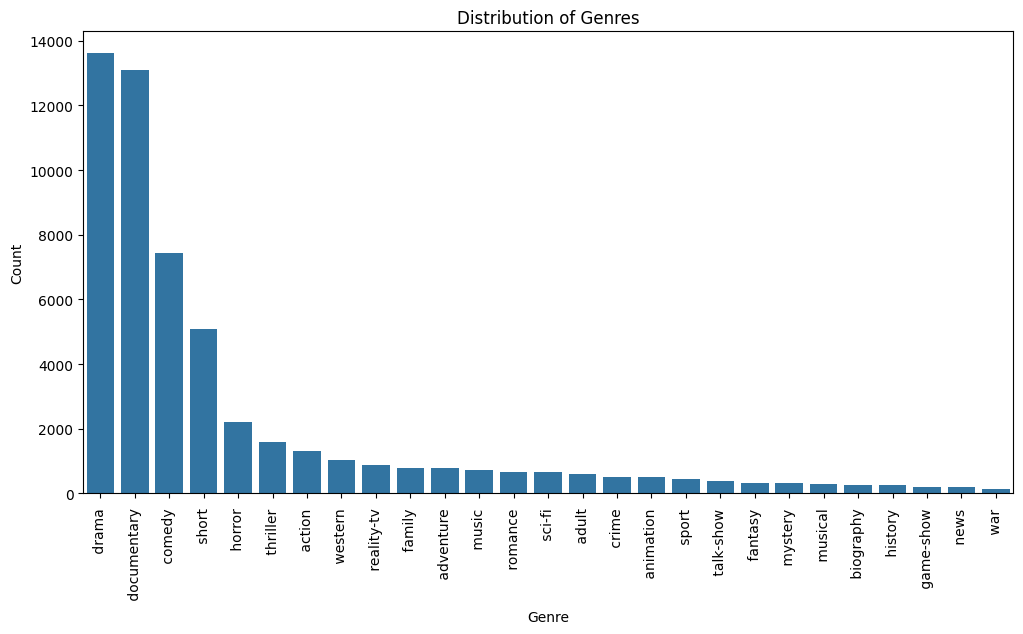

In [13]:
plt.figure(figsize=(12,6))
sns.barplot(x=train_df['Genre'].value_counts().index, y=train_df['Genre'].value_counts())
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Distribution of Genres')
plt.xticks(rotation=90)
plt.show();

In [14]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imgks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
nltk.download('punkt')
nltk.download('stopwords')
# Define the clean_text function
def filtration(word):
    word = word.lower()  # Lowercase all characters
    word = re.sub(r'@\S+', '', word)  # Remove Twitter handles
    word = re.sub(r'http\S+', '', word)  # Remove URLs
    word = re.sub(r'pic.\S+', '', word)
    word = re.sub(r"[^a-zA-Z+']", ' ', word)  # Keep only characters
    word = re.sub(r'\s+[a-zA-Z]\s+', ' ', word + ' ')  # Keep words with length > 1 only
    word = "".join([i for i in word if i not in string.punctuation])
    words = nltk.word_tokenize(word)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    word = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    word = re.sub(r"\s[\s]+", " ", word).strip()  # Remove repeated/leading/trailing spaces
    return word

# Apply the clean_text function to the 'Description' column in the training and test data
train_df['Text_filtration'] = train_df['Description'].apply(filtration)
test_df['Text_filtration'] = test_df['Description'].apply(filtration)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\imgks\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imgks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
train_df.head(10)

,Title,Genre,Description,Text_filtration
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films title refers recovered bodies ground zer...
6,Quality Control (2011),documentary,Quality Control consists of a series of 16mm ...,quality control consists series single take sh...
7,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...,tough economic times max joey run ideas discov...
8,One Step Away (1985),crime,Ron Petrie (Keanu Reeves) is a troubled teen ...,ron petrie keanu reeves troubled teen whose li...
9,"""Desperate Hours"" (2016)",reality-tv,"A sudden calamitous event, causing great loss...",sudden calamitous event causing great loss lif...
10,Spirits (2014/I),horror,Four high school students embark on a terrify...,four high school students embark terrifying jo...


In [17]:
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_df['Text_filtration'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_df['Text_filtration'])

In [18]:
#Splitting data 
X = X_train
y = train_df['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Initialize and train a Multinomial Naive Bayes classifier
classifier_nbc = MultinomialNB()
classifier_nbc.fit(X_train, y_train)

MultinomialNB()

In [20]:
classifier_svc = SVC()

In [21]:
classifier_svc.fit(X_train,y_train)

SVC()

In [22]:
y_pred_nbc = classifier_nbc.predict(X_val)
y_pred_nbc

array([' drama ', ' drama ', ' drama ', ..., ' drama ', ' documentary ',
       ' drama '], dtype='<U13')

In [23]:
y_pred_svc = classifier_svc.predict(X_val)
y_pred_svc

array([' drama ', ' drama ', ' comedy ', ..., ' drama ', ' drama ',
       ' horror '], dtype=object)

In [24]:
accuracy_nbc = accuracy_score(y_val,y_pred_nbc)
print("Validation Accuracy:", accuracy_nbc)
#print(classification_report(y_val, y_pred))

Validation Accuracy: 0.44526422576777647


In [25]:
accuracy_svc = accuracy_score(y_val,y_pred_svc)
print("Validation Accuracy:", accuracy_svc)

Validation Accuracy: 0.5691229364567002


In [27]:
from sklearn.ensemble import VotingClassifier
ensemble_classifier = VotingClassifier(estimators=[
    ("model_1",classifier_nbc),
    ("model_2",classifier_svc)
],voting = "hard"
)

ensemble_classifier.fit(X_train, y_train)

ensemble_predictions = ensemble_classifier.predict(X_val)
accuracy_ensemble = accuracy_score(y_val,ensemble_predictions)
print("Validation Accuracy:", accuracy_ensemble)

Validation Accuracy: 0.5063174398229272
